In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from sklearn.feature_selection import RFE
import json

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error


In [67]:
df = pd.read_csv('tvol_lidarLiveP.csv')
df.head()

,Status,origin,zmax,zmean,zsd,zskew,zkurt,pzabovezmean,pzabove2,zq5,...,zpcum1,zpcum2,zpcum3,zpcum4,zpcum5,zpcum6,zpcum7,zpcum8,zpcum9,Target
0,1,0,0.482936,0.393575,0.640931,0.417088,0.000799,0.653559,0.543409,0.000000,...,0.228816,0.217799,0.216589,0.214684,0.208958,0.211244,0.275474,0.485716,0.702998,395.095030
1,1,0,0.619445,0.744484,0.669192,0.315335,0.035721,0.972526,0.832260,0.000000,...,0.066177,0.098509,0.116252,0.120479,0.113527,0.112180,0.112576,0.120256,0.182446,846.770732
2,1,0,0.590965,0.552324,0.719417,0.387989,0.005110,0.749769,0.738540,0.000000,...,0.217498,0.280967,0.292151,0.288404,0.281392,0.280213,0.282977,0.416297,0.870808,500.279343
3,1,0,0.585318,0.735132,0.211343,0.251785,0.194261,0.687752,0.986705,0.679823,...,0.001473,0.000000,0.000000,0.000000,0.010708,0.162536,0.361051,0.722317,0.873967,526.744001
4,1,0,0.297815,0.381137,0.203122,0.251367,0.095055,0.959945,0.893755,0.000000,...,0.050555,0.047751,0.052850,0.056430,0.053567,0.110090,0.504414,0.914992,0.984998,327.607715


In [69]:
df = df.sample(frac=1, random_state=42)

X = df.drop('Target', axis=1)  # Drops the Target column and uses the rest as features
y = df['Target']               # Sets the Target column as the dependent variable


In [71]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Prepare to collect the metrics
metrics = {name: {'MAE': [], 'RMSE': [], 'R2': []} for name in models.keys()}


Average Metrics for Each Model:


,MAE,RMSE,R2
Linear Regression,75.165844,99.185243,0.611515
Random Forest,60.422030,81.762213,0.752992
XGBoost,67.521293,91.841549,0.698074


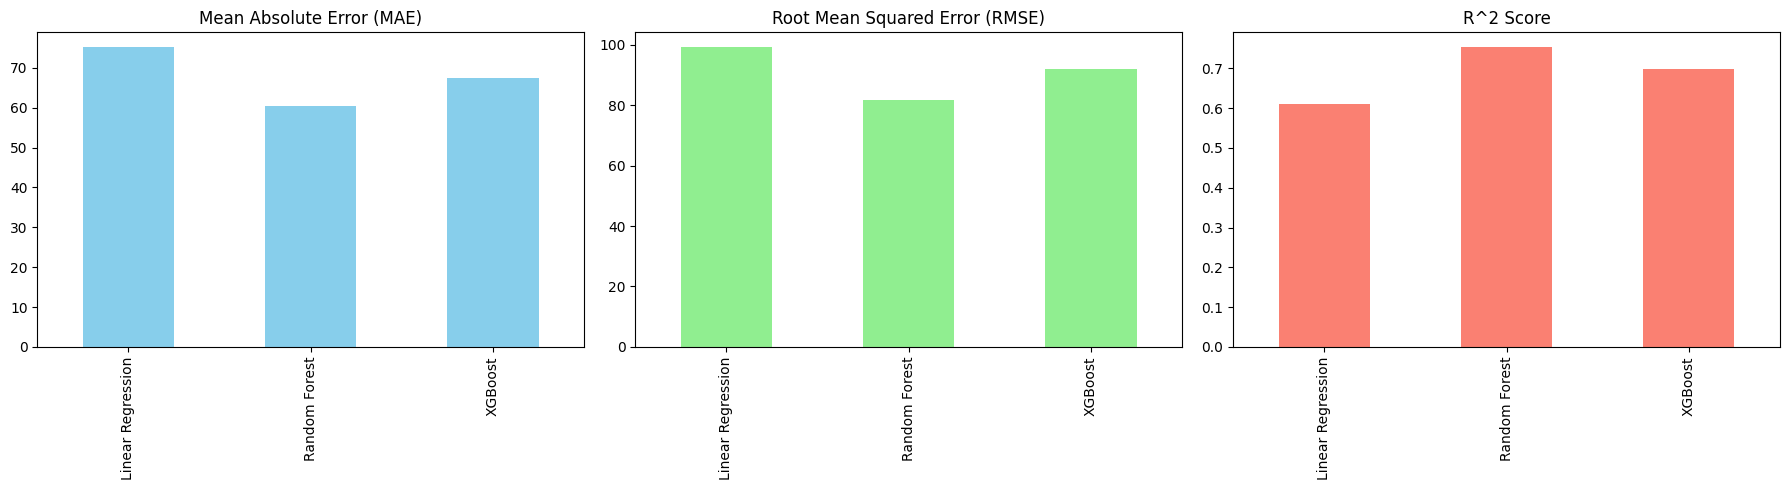

In [73]:
import pandas as pd
import matplotlib.pyplot as plt


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Store metrics
        metrics[name]['MAE'].append(mae)
        metrics[name]['RMSE'].append(rmse)
        metrics[name]['R2'].append(r2)

# Convert the metrics dictionary to a DataFrame for easy tabular representation
results_df = pd.DataFrame({name: {
    'MAE': np.mean(metrics[name]['MAE']),
    'RMSE': np.mean(metrics[name]['RMSE']),
    'R2': np.mean(metrics[name]['R2'])
} for name in models.keys()}).T  # Transpose to make models as rows

print("Average Metrics for Each Model:")
display(results_df)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
results_df['MAE'].plot(kind='bar', ax=ax[0], color='skyblue', title='Mean Absolute Error (MAE)')
results_df['RMSE'].plot(kind='bar', ax=ax[1], color='lightgreen', title='Root Mean Squared Error (RMSE)')
results_df['R2'].plot(kind='bar', ax=ax[2], color='salmon', title='R^2 Score')
plt.tight_layout()
plt.show()


In [74]:
# Initialize variables to find the best model based on RMSE
best_model_name = None
best_rmse = float('inf')

# Iterate through the results to find the model with the lowest RMSE
for name, scores in metrics.items():
    avg_rmse = np.mean(scores['RMSE'])
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_model_name = name

# Fit the best model on the entire dataset
best_model = models[best_model_name].fit(X, y)

# Save the best model
import pickle
pickle.dump(best_model, open(f"{best_model_name}_Baseline.pkl", 'wb'))

print(f"Saved {best_model_name} as the best model based on RMSE.")


Saved Random Forest as the best model based on RMSE.


In [77]:
# Initialize variables to find the best model based on R^2
best_model_name = None
best_r2 = float('-inf')  # Start with the lowest possible R^2

# Iterate through the results to find the model with the highest R^2
for name, scores in metrics.items():
    avg_r2 = np.mean(scores['R2'])
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_model_name = name

# Fit the best model on the entire dataset
best_model = models[best_model_name].fit(X, y)

# Save the best model
import pickle
pickle.dump(best_model, open(f"{best_model_name}_Baseline.pkl", 'wb'))

print(f"Saved {best_model_name} as the best model based on R^2 score with an average R^2 of {best_r2:.3f}.")


Saved Random Forest as the best model based on R^2 score with an average R^2 of 0.753.


Week n+1 - Feature Selection

In [82]:
# Feature Selection with Random Forest (RF) and XGBoost (XGB)
#Train Models to Get Feature Importances

# Assuming X is a DataFrame where columns are feature names
# and y is the target variable.

# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)
rf_importances = rf_model.feature_importances_

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X, y)
xgb_importances = xgb_model.feature_importances_

# Create a DataFrame to visualize feature importances from both models
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'RF Importance': rf_importances,
    'XGB Importance': xgb_importances
})

# Sort the DataFrame to show more important features first
feature_importances = feature_importances.sort_values(by='RF Importance', ascending=False)

# Display the DataFrame
print(feature_importances)


         Feature  RF Importance  XGB Importance
21          zq65       0.269917        0.626739
22          zq70       0.140145        0.147737
24          zq80       0.116061        0.081965
23          zq75       0.105575        0.005119
20          zq60       0.062312        0.005836
3          zmean       0.041708        0.008478
19          zq55       0.033445        0.018350
18          zq50       0.027562        0.002620
25          zq85       0.026812        0.009429
26          zq90       0.015285        0.004483
36        zpcum9       0.013839        0.002486
9            zq5       0.012734        0.010938
27          zq95       0.010530        0.009664
17          zq45       0.010509        0.009521
2           zmax       0.009440        0.000854
4            zsd       0.009327        0.007010
35        zpcum8       0.008861        0.002171
29        zpcum2       0.007727        0.006425
7   pzabovezmean       0.007576        0.002620
33        zpcum6       0.006040        0

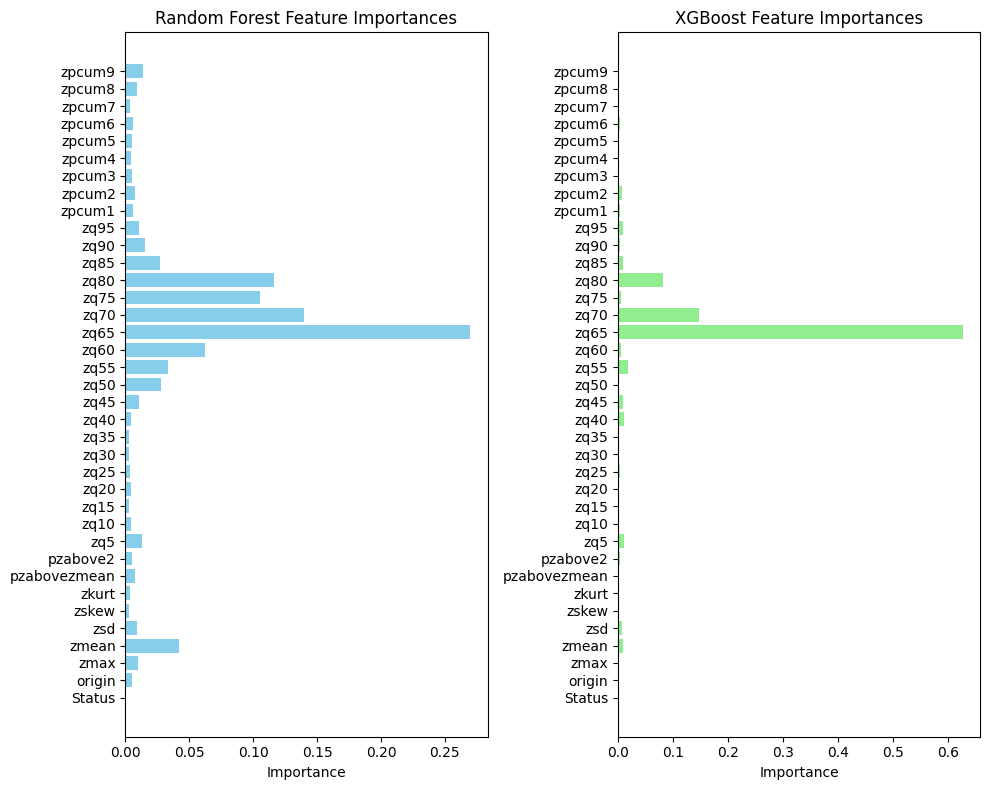

In [84]:
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

# Select features greater than the median importance
features_rf = X.columns[rf_importances > np.median(rf_importances)].tolist()
features_xgb = X.columns[xgb_importances > np.median(xgb_importances)].tolist()

# Save the selected features to JSON files
with open('Features_RF.json', 'w') as f:
    json.dump(features_rf, f)
with open('Features_XGB.json', 'w') as f:
    json.dump(features_xgb, f)

# Create a DataFrame to visualize feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'RF Importance': rf_importances,
    'XGB Importance': xgb_importances
})

# Visualizing feature importances
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.barh(feature_importances['Feature'], feature_importances['RF Importance'], color='skyblue')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
plt.barh(feature_importances['Feature'], feature_importances['XGB Importance'], color='lightgreen')
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

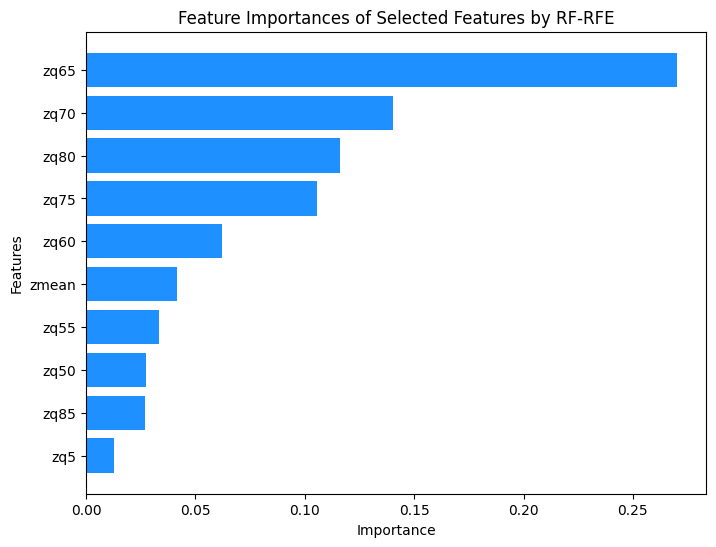

In [86]:
#RF-RFE (Recursive Feature Elimination with RF)
#Apply RFE


selector = RFE(rf_model, n_features_to_select=10, step=1)  # adjust 'n_features_to_select' as needed
selector.fit(X, y)

# Get the list of features selected by RFE
rfe_features = X.columns[selector.support_].tolist()

# Save the RFE features to JSON
with open('Features_RFE_RF.json', 'w') as f:
    json.dump(rfe_features, f)

# Extracting the importances of the selected features
rfe_importances = rf_model.feature_importances_[selector.support_]

# Create a DataFrame for visualization
rfe_feature_importances = pd.DataFrame({
    'Feature': rfe_features,
    'Importance': rfe_importances
}).sort_values(by='Importance', ascending=True)

# Visualize the feature importances
plt.figure(figsize=(8, 6))
plt.barh(rfe_feature_importances['Feature'], rfe_feature_importances['Importance'], color='dodgerblue')
plt.title('Feature Importances of Selected Features by RF-RFE')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


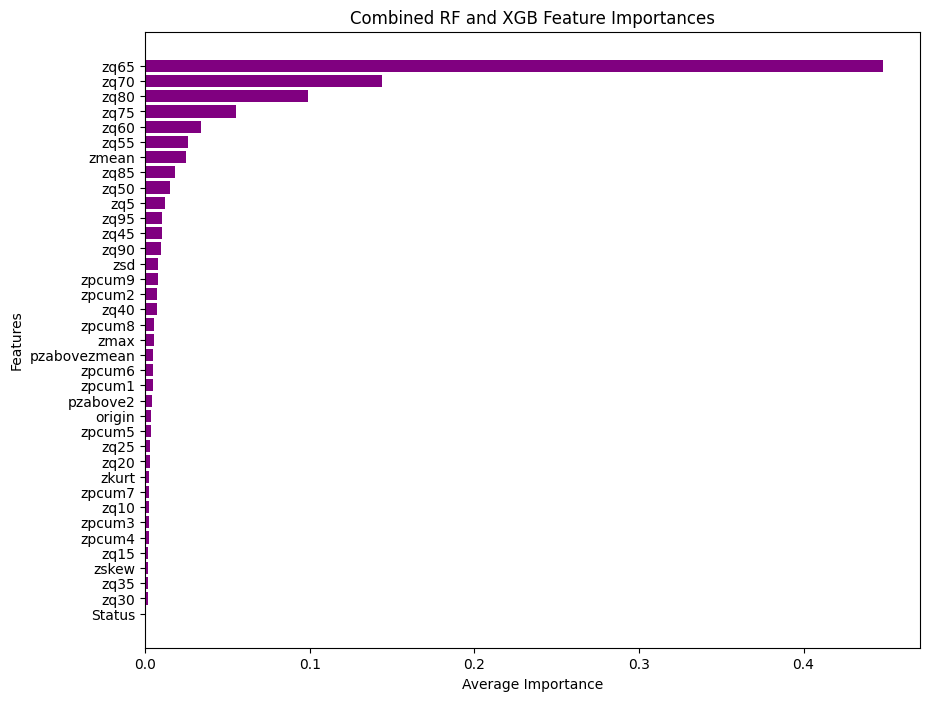

In [87]:
#Combined RF and XGB Feature Importances
#Combine and Select Features


xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X, y)
xgb_importances = xgb_model.feature_importances_

# Combine the importances
combined_importances = (rf_importances + xgb_importances) / 2

# Select features whose combined importance is greater than the median
selected_features = X.columns[combined_importances > np.median(combined_importances)].tolist()

# Save the selected features to JSON
with open('Features_RF_XGB.json', 'w') as f:
    json.dump(selected_features, f)

# Create a DataFrame for visualization
combined_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Combined Importance': combined_importances
}).sort_values(by='Combined Importance', ascending=True)

# Visualize the combined feature importances
plt.figure(figsize=(10, 8))
plt.barh(combined_feature_importances['Feature'], combined_feature_importances['Combined Importance'], color='purple')
plt.title('Combined RF and XGB Feature Importances')
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.show()


zq65 importance came as most important

Cross Validation k fold

In [91]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score

# Load your dataset
df = pd.read_csv('tvol_lidarLiveP.csv')
X = df.drop('Target', axis=1)
y = df['Target']

# Set up KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)


In [93]:
# Paths to the feature sets
feature_set_files = {
    'RF': 'Features_RF.json',
    'RFE_RF': 'Features_RFE_RF.json',
    'RF_XGB': 'Features_RF_XGB.json',
    'XGB': 'Features_XGB.json'
}

# Load feature sets
feature_sets = {}
for key, filepath in feature_set_files.items():
    with open(filepath, 'r') as file:
        features = json.load(file)
        feature_sets[key] = features


In [95]:
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}


In [97]:
# Results dictionary to store the cross-validation results
results = {}

# Evaluate each feature set with each model
for feature_name, features in feature_sets.items():
    results[feature_name] = {}
    X_selected = X[features]
    for model_name, model in models.items():
        # Perform cross-validation
        scores = cross_val_score(model, X_selected, y, cv=kf, scoring='r2')  # Change scoring to 'neg_mean_squared_error' for RMSE
        results[feature_name][model_name] = np.mean(scores)

# Print the results
for feature_set, model_scores in results.items():
    print(f"Results for feature set {feature_set}:")
    for model_name, score in model_scores.items():
        print(f"  {model_name}: Average R^2 Score = {score}")


Results for feature set RF:
  Random Forest: Average R^2 Score = 0.7468044299714547
  XGBoost: Average R^2 Score = 0.6753995958178092
Results for feature set RFE_RF:
  Random Forest: Average R^2 Score = 0.7426608907484559
  XGBoost: Average R^2 Score = 0.6804236902897197
Results for feature set RF_XGB:
  Random Forest: Average R^2 Score = 0.7469853987156213
  XGBoost: Average R^2 Score = 0.6793311100067765
Results for feature set XGB:
  Random Forest: Average R^2 Score = 0.7442928549197744
  XGBoost: Average R^2 Score = 0.664405874957958


In [98]:
import json
import pickle

# Save the best feature sets for each model
best_features_rf = feature_sets['RF_XGB']
best_features_xgb = feature_sets['RFE_RF']

with open('Best_Features_RF.json', 'w') as f:
    json.dump(best_features_rf, f)

with open('Best_Features_XGB.json', 'w') as f:
    json.dump(best_features_xgb, f)

# Train and save the best models
best_model_rf = RandomForestRegressor(random_state=42)
best_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

best_model_rf.fit(X[best_features_rf], y)
best_model_xgb.fit(X[best_features_xgb], y)

with open('RF_RF_XGB.pkl', 'wb') as f:
    pickle.dump(best_model_rf, f)

with open('RFE_RF_XGB.pkl', 'wb') as f:
    pickle.dump(best_model_xgb, f)


Week n+ 2 other features

In [102]:
# Top features from RF and XGB
rf_features = ["zmean", "zsd", "zq5", "zq40", "zq45", "zq50", "zq55", "zq60", "zq65", "zq70", "zq75", "zq80", "zq85", "zq90", "zq95", "zpcum2", "zpcum8", "zpcum9"]
xgb_features = ["zmean", "zq5", "zq50", "zq55", "zq60", "zq65", "zq70", "zq75", "zq80", "zq85"]

# Combine all unique top features for evaluation
all_top_features = list(set(rf_features + xgb_features))


In [103]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


In [109]:
# Print column names from DataFrame
print("Columns in DataFrame:", X.columns.tolist())

# Print your list of features
print("Selected features for analysis:", all_top_features)


Columns in DataFrame: ['Status', 'origin', 'zmax', 'zmean', 'zsd', 'zskew', 'zkurt', 'pzabovezmean', 'pzabove2', 'zq5', 'zq10', 'zq15', 'zq20', 'zq25', 'zq30', 'zq35', 'zq40', 'zq45', 'zq50', 'zq55', 'zq60', 'zq65', 'zq70', 'zq75', 'zq80', 'zq85', 'zq90', 'zq95', 'zpcum1', 'zpcum2', 'zpcum3', 'zpcum4', 'zpcum5', 'zpcum6', 'zpcum7', 'zpcum8', 'zpcum9']
Selected features for analysis: ['zq95', 'zq75', 'zsd', 'zq45', 'zq85', 'zq90', 'zq40', 'zq80', 'zpcum9', 'zpcum2', 'zmean', 'zq60', 'zpcum8', 'zq65', 'zq55', 'zq70', 'zq50', 'zq5']


In [115]:
# Evaluate each feature with both models
for feature in all_top_features:
    if feature in X.columns:  # Check if the feature is in the DataFrame columns
        # Select the current feature for model training
        X_feature = X[[feature]]

        # Initialize lists to store cross-validation scores
        rf_scores = []
        xgb_scores = []

        # Perform cross-validation
        for train_index, test_index in kf.split(X_feature):
            X_train, X_test = X_feature.iloc[train_index], X_feature.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Random Forest
            rf_model.fit(X_train, y_train)
            y_pred_rf = rf_model.predict(X_test)
            rf_scores.append(r2_score(y_test, y_pred_rf))

            # XGBoost
            xgb_model.fit(X_train, y_train)
            y_pred_xgb = xgb_model.predict(X_test)
            xgb_scores.append(r2_score(y_test, y_pred_xgb))

        # Store average scores
        feature_scores['Random Forest'][feature] = np.mean(rf_scores)
        feature_scores['XGBoost'][feature] = np.mean(xgb_scores)
    else:
        print(f"Feature not found: {feature}")


In [116]:
# Print the R^2 scores for each feature and model
for model in feature_scores:
    print(f"Model: {model}")
    for feature, score in feature_scores[model].items():
        print(f"  Feature: {feature}, R^2 Score: {score:.4f}")


Model: Random Forest
  Feature: zq95, R^2 Score: 0.2059
  Feature: zq75, R^2 Score: 0.6076
  Feature: zsd, R^2 Score: -0.2097
  Feature: zq45, R^2 Score: 0.3744
  Feature: zq85, R^2 Score: 0.5649
  Feature: zq90, R^2 Score: 0.3338
  Feature: zq40, R^2 Score: 0.2799
  Feature: zq80, R^2 Score: 0.6393
  Feature: zpcum9, R^2 Score: -0.2722
  Feature: zpcum2, R^2 Score: -0.3588
  Feature: zmean, R^2 Score: 0.5082
  Feature: zq60, R^2 Score: 0.5993
  Feature: zpcum8, R^2 Score: -0.2009
  Feature: zq65, R^2 Score: 0.5597
  Feature: zq55, R^2 Score: 0.5593
  Feature: zq70, R^2 Score: 0.5964
  Feature: zq50, R^2 Score: 0.4643
  Feature: zq5, R^2 Score: -0.3929
Model: XGBoost
  Feature: zq95, R^2 Score: -0.0032
  Feature: zq75, R^2 Score: 0.5368
  Feature: zsd, R^2 Score: -0.4977
  Feature: zq45, R^2 Score: 0.1975
  Feature: zq85, R^2 Score: 0.4564
  Feature: zq90, R^2 Score: 0.0772
  Feature: zq40, R^2 Score: 0.0694
  Feature: zq80, R^2 Score: 0.5535
  Feature: zpcum9, R^2 Score: -0.6249
  Fea

,Random Forest,XGBoost
zq95,0.205852,-0.003214
zq75,0.607559,0.536793
zsd,-0.209717,-0.497696
zq45,0.374393,0.197455
zq85,0.564877,0.456379
zq90,0.333783,0.077156
zq40,0.279874,0.069422
zq80,0.639320,0.553542
zpcum9,-0.272197,-0.624905
zpcum2,-0.358825,-0.773912


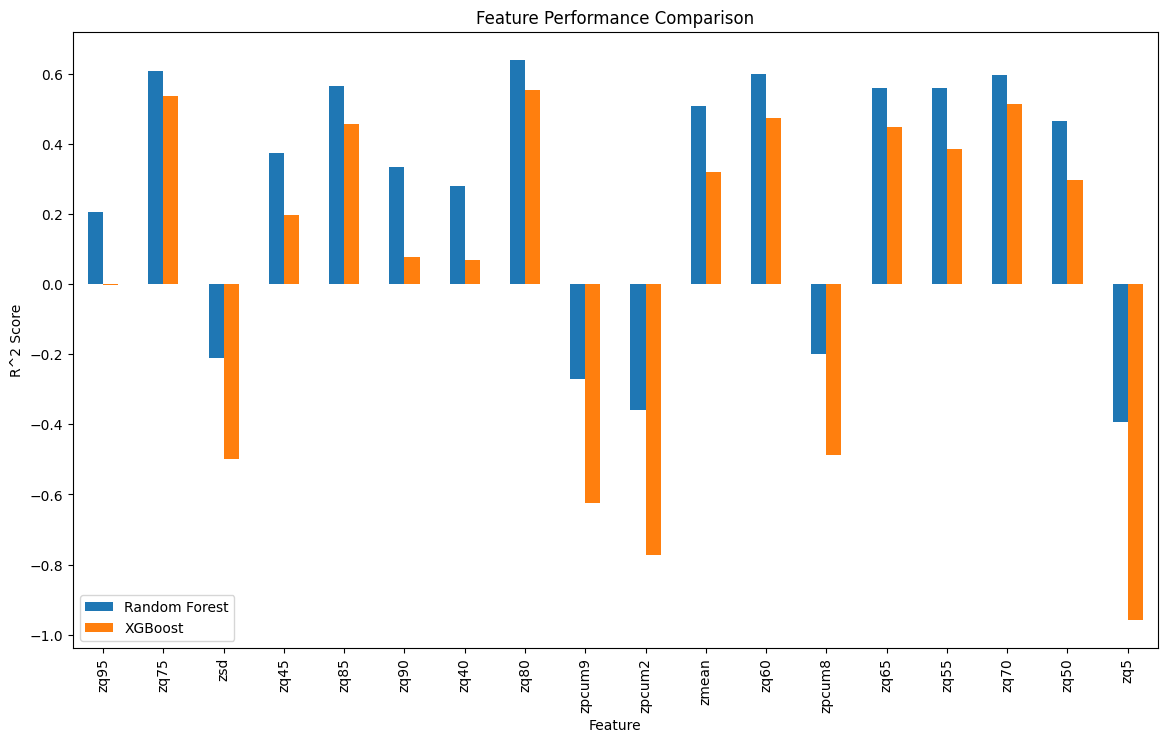

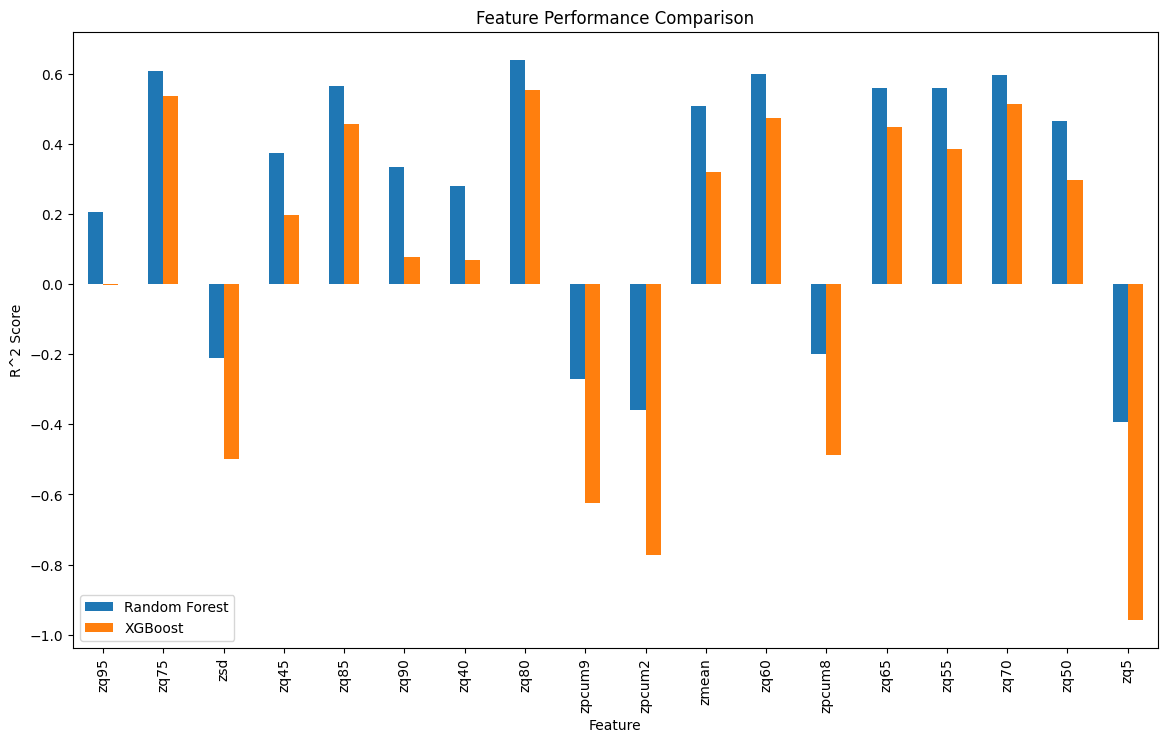

<Figure size 640x480 with 0 Axes>

In [143]:
# Convert the feature_scores dictionary to a DataFrame
scores_df = pd.DataFrame(feature_scores)
#print(scores_df)


# Display the DataFrame as a table
display(scores_df)


# Plotting the results
ax = scores_df.plot(kind='bar', figsize=(14, 8), title='Feature Performance Comparison')
ax.set_xlabel('Feature')
ax.set_ylabel('R^2 Score')
plt.show()


# Plotting the results
ax = scores_df.plot(kind='bar', figsize=(14, 8), title='Feature Performance Comparison')
ax.set_xlabel('Feature')
ax.set_ylabel('R^2 Score')
plt.show()


plt.savefig('feature_performance_comparison.png')




In [121]:
import pandas as pd
from sklearn.model_selection import KFold

# Load the data
df = pd.read_csv('tvol_lidarLiveP.csv')
df = df.sample(frac=1, random_state=42)  # Shuffle the dataset

X = df.drop('Target', axis=1)  # Drops the Target column and uses the rest as features
y = df['Target'] 


# List your top 8 features
top_features = ["zmean", "zq5", "zq50", "zq55", "zq60", "zq65", "zq70", "zq75"]


In [123]:
from itertools import combinations

# Generate combinations of features from 3 to 5
feature_combinations = []
for r in range(3, 6):
    feature_combinations.extend(combinations(top_features, r))


In [125]:
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import r2_score
import numpy as np

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store scores
combination_scores = {}

# Model initialization
model = RandomForestRegressor(random_state=42)

# Evaluate each combination
for combination in feature_combinations:
    X_subset = X[list(combination)]
    scores = []
    for train_index, test_index in kf.split(X_subset):
        X_train, X_test = X_subset.iloc[train_index], X_subset.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(r2_score(y_test, y_pred))

    combination_scores[combination] = np.mean(scores)


In [127]:
# Identify the best combination
best_combination = max(combination_scores, key=combination_scores.get)
best_score = combination_scores[best_combination]

# Train the final model on the entire dataset with the best combination
final_model = RandomForestRegressor(random_state=42)
final_model.fit(X[list(best_combination)], y)

# Save the final model
import pickle
with open('Best_Model_Combination.pkl', 'wb') as f:
    pickle.dump(final_model, f)


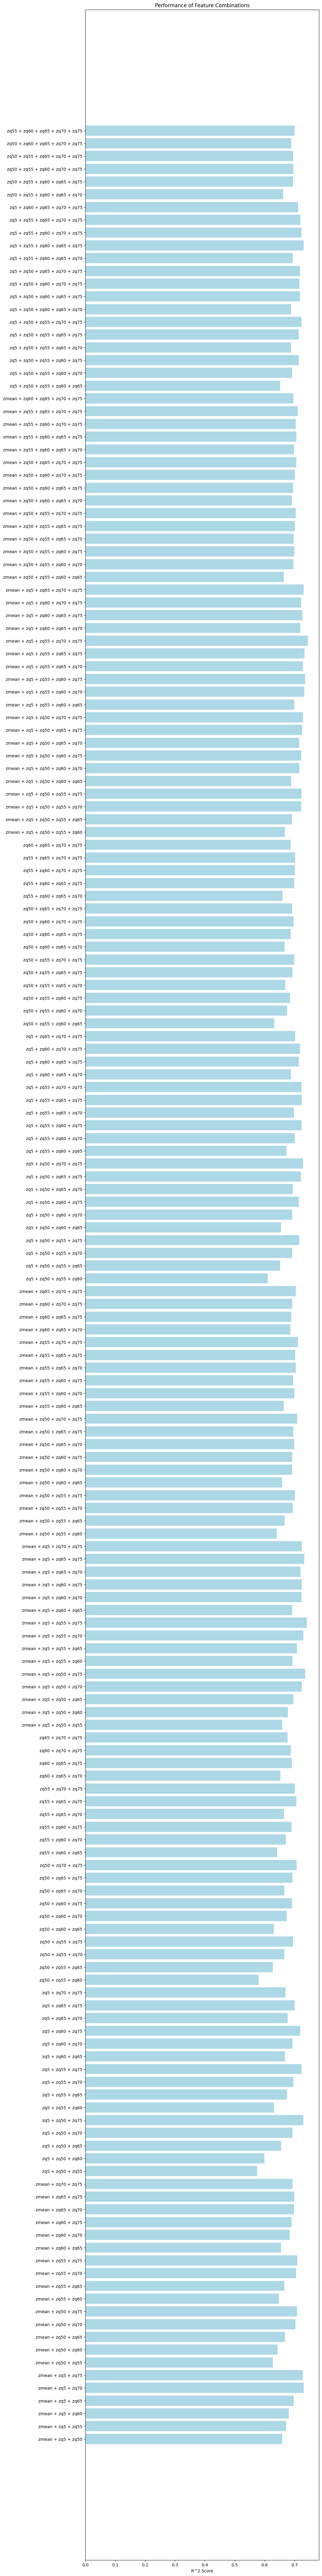

In [139]:
import matplotlib.pyplot as plt

# Data for plotting
combinations = [' + '.join(c) for c in combination_scores.keys()]
scores = list(combination_scores.values())

plt.figure(figsize=(10, 110))
plt.barh(combinations, scores, color='lightblue')
plt.xlabel('R^2 Score')
plt.title('Performance of Feature Combinations')
plt.show()


In [145]:
# Assuming `combination_scores` holds the average score for each feature combination
best_combination = max(combination_scores, key=combination_scores.get)
best_score = combination_scores[best_combination]


In [149]:
# Retrain the model on the entire dataset with the best feature set
final_model = RandomForestRegressor(random_state=42) 
final_model.fit(X[list(best_combination)], y)


RandomForestRegressor(random_state=42)

In [151]:
# Save the model
import pickle
with open('RF_RF_XGB.pkl', 'wb') as file:  
    pickle.dump(final_model, file)


In [157]:
# Save the model
import pickle
with open('RFE_RF_XGB.pkl', 'wb') as file:  
    pickle.dump(final_model, file)


In [159]:
# Example dictionary to keep track of the best models and their scores
best_models = {
    'RF_RF_XGB': {'model': None, 'score': -float('inf')},
    'RFE_RF_XGB': {'model': None, 'score': -float('inf')}
}

# Update this dictionary based on actual evaluations
for combination, score in combination_scores.items():
    model_identifier = 'RF_RF_XGB'  # Update logic to assign the correct identifier
    if score > best_models[model_identifier]['score']:
        # Update the best model for this identifier
        best_model = RandomForestRegressor(random_state=42)
        best_model.fit(X[list(combination)], y)
        best_models[model_identifier] = {'model': best_model, 'score': score}

# Now save all best models
for identifier, info in best_models.items():
    with open(f'{identifier}.pkl', 'wb') as file:
        pickle.dump(info['model'], file)


In [161]:
import logging

# Setting up logging to display the model evaluation process
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [163]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

# Assuming top_features and X, y are already defined
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestRegressor(random_state=42)  # Example model
combination_scores = {}

for combination in feature_combinations:
    X_subset = X[list(combination)]
    scores = cross_val_score(model, X_subset, y, cv=kf, scoring='r2')
    average_score = np.mean(scores)
    combination_scores[combination] = average_score
    logging.info(f"Evaluated combination: {combination} | Average R^2 score: {average_score}")

# Identifying the best combination
best_combination = max(combination_scores, key=combination_scores.get)
best_score = combination_scores[best_combination]
logging.info(f"Best combination: {best_combination} with R^2 score: {best_score}")


2025-03-11 10:41:12,741 - INFO - Evaluated combination: ('zmean', 'zq5', 'zq50') | Average R^2 score: 0.6585124824102556
2025-03-11 10:41:13,471 - INFO - Evaluated combination: ('zmean', 'zq5', 'zq55') | Average R^2 score: 0.6716790449934085
2025-03-11 10:41:14,213 - INFO - Evaluated combination: ('zmean', 'zq5', 'zq60') | Average R^2 score: 0.6812353297240387
2025-03-11 10:41:14,896 - INFO - Evaluated combination: ('zmean', 'zq5', 'zq65') | Average R^2 score: 0.6974396671409877
2025-03-11 10:41:15,586 - INFO - Evaluated combination: ('zmean', 'zq5', 'zq70') | Average R^2 score: 0.7309408862873186
2025-03-11 10:41:16,268 - INFO - Evaluated combination: ('zmean', 'zq5', 'zq75') | Average R^2 score: 0.7271313829561856
2025-03-11 10:41:16,983 - INFO - Evaluated combination: ('zmean', 'zq50', 'zq55') | Average R^2 score: 0.6272158375720626
2025-03-11 10:41:17,683 - INFO - Evaluated combination: ('zmean', 'zq50', 'zq60') | Average R^2 score: 0.6433128554556592
2025-03-11 10:41:18,395 - INFO

In [165]:
# Retrain the model on the best feature combination
final_model = RandomForestRegressor(random_state=42)
final_model.fit(X[list(best_combination)], y)

# Save the model
import pickle
with open('Best_Model_Combination.pkl', 'wb') as f:
    pickle.dump(final_model, f)
logging.info(f"Trained and saved the best model based on combination: {best_combination}")


2025-03-11 10:46:19,679 - INFO - Trained and saved the best model based on combination: ('zmean', 'zq5', 'zq55', 'zq70', 'zq75')


In [169]:
import logging

class ListHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        self.log_records = []

    def emit(self, record):
        self.log_records.append(self.format(record))

# Set up logging with ListHandler
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Clear existing handlers if rerunning this setup
logger.handlers = []

# Create and add the list handler
list_handler = ListHandler()
logger.addHandler(list_handler)


In [171]:
# Example logging in your process
logger.info("Starting model evaluation.")

# Dummy example to add more logs
for i in range(5):
    logger.info(f"Processed iteration {i}")

# Print all logged messages
print("Review of Model Selection Process:")
for record in list_handler.log_records:
    print(record)


Review of Model Selection Process:
Starting model evaluation.
Processed iteration 0
Processed iteration 1
Processed iteration 2
Processed iteration 3
Processed iteration 4
